# Risk forecasting DNN model

In [11]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split

In [13]:
SERIES_PERIOD = '10y'
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = 0.9
EPOCHS = 10
BATCH_SIZE = 32

### Dataset

In [14]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# fetch VIX volatility data
vix = '^VIX'
vix_data = yf.Ticker(vix)
vix_history = vix_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
vix_close = vix_history.Close.loc[vix_history.Close != 0][:-1]

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'close': close,
    'returns': (log_returns - log_returns.mean()) / log_returns.std(),
    'vix': (vix_close - vix_close.mean()) / vix_close.std(),
    'volatility': (volatility - volatility.mean()) / volatility.std()
})
X.dropna(inplace=True)
X

,close,returns,vix,volatility
Date,,,,
2012-06-11,1308.930054,-1.231793,0.872357,0.664908
2012-06-12,1324.180054,1.039295,0.664860,0.715954
2012-06-13,1314.880005,-0.703166,0.972577,0.270656
2012-06-14,1329.099976,0.961971,0.606986,0.421980
2012-06-15,1342.839966,0.917842,0.526528,0.468211
...,...,...,...,...
2022-05-26,4057.840088,1.797276,1.428507,0.531248
2022-05-27,4158.240234,2.241786,1.177252,0.668043
2022-05-31,4132.149902,-0.632659,1.243595,0.932627


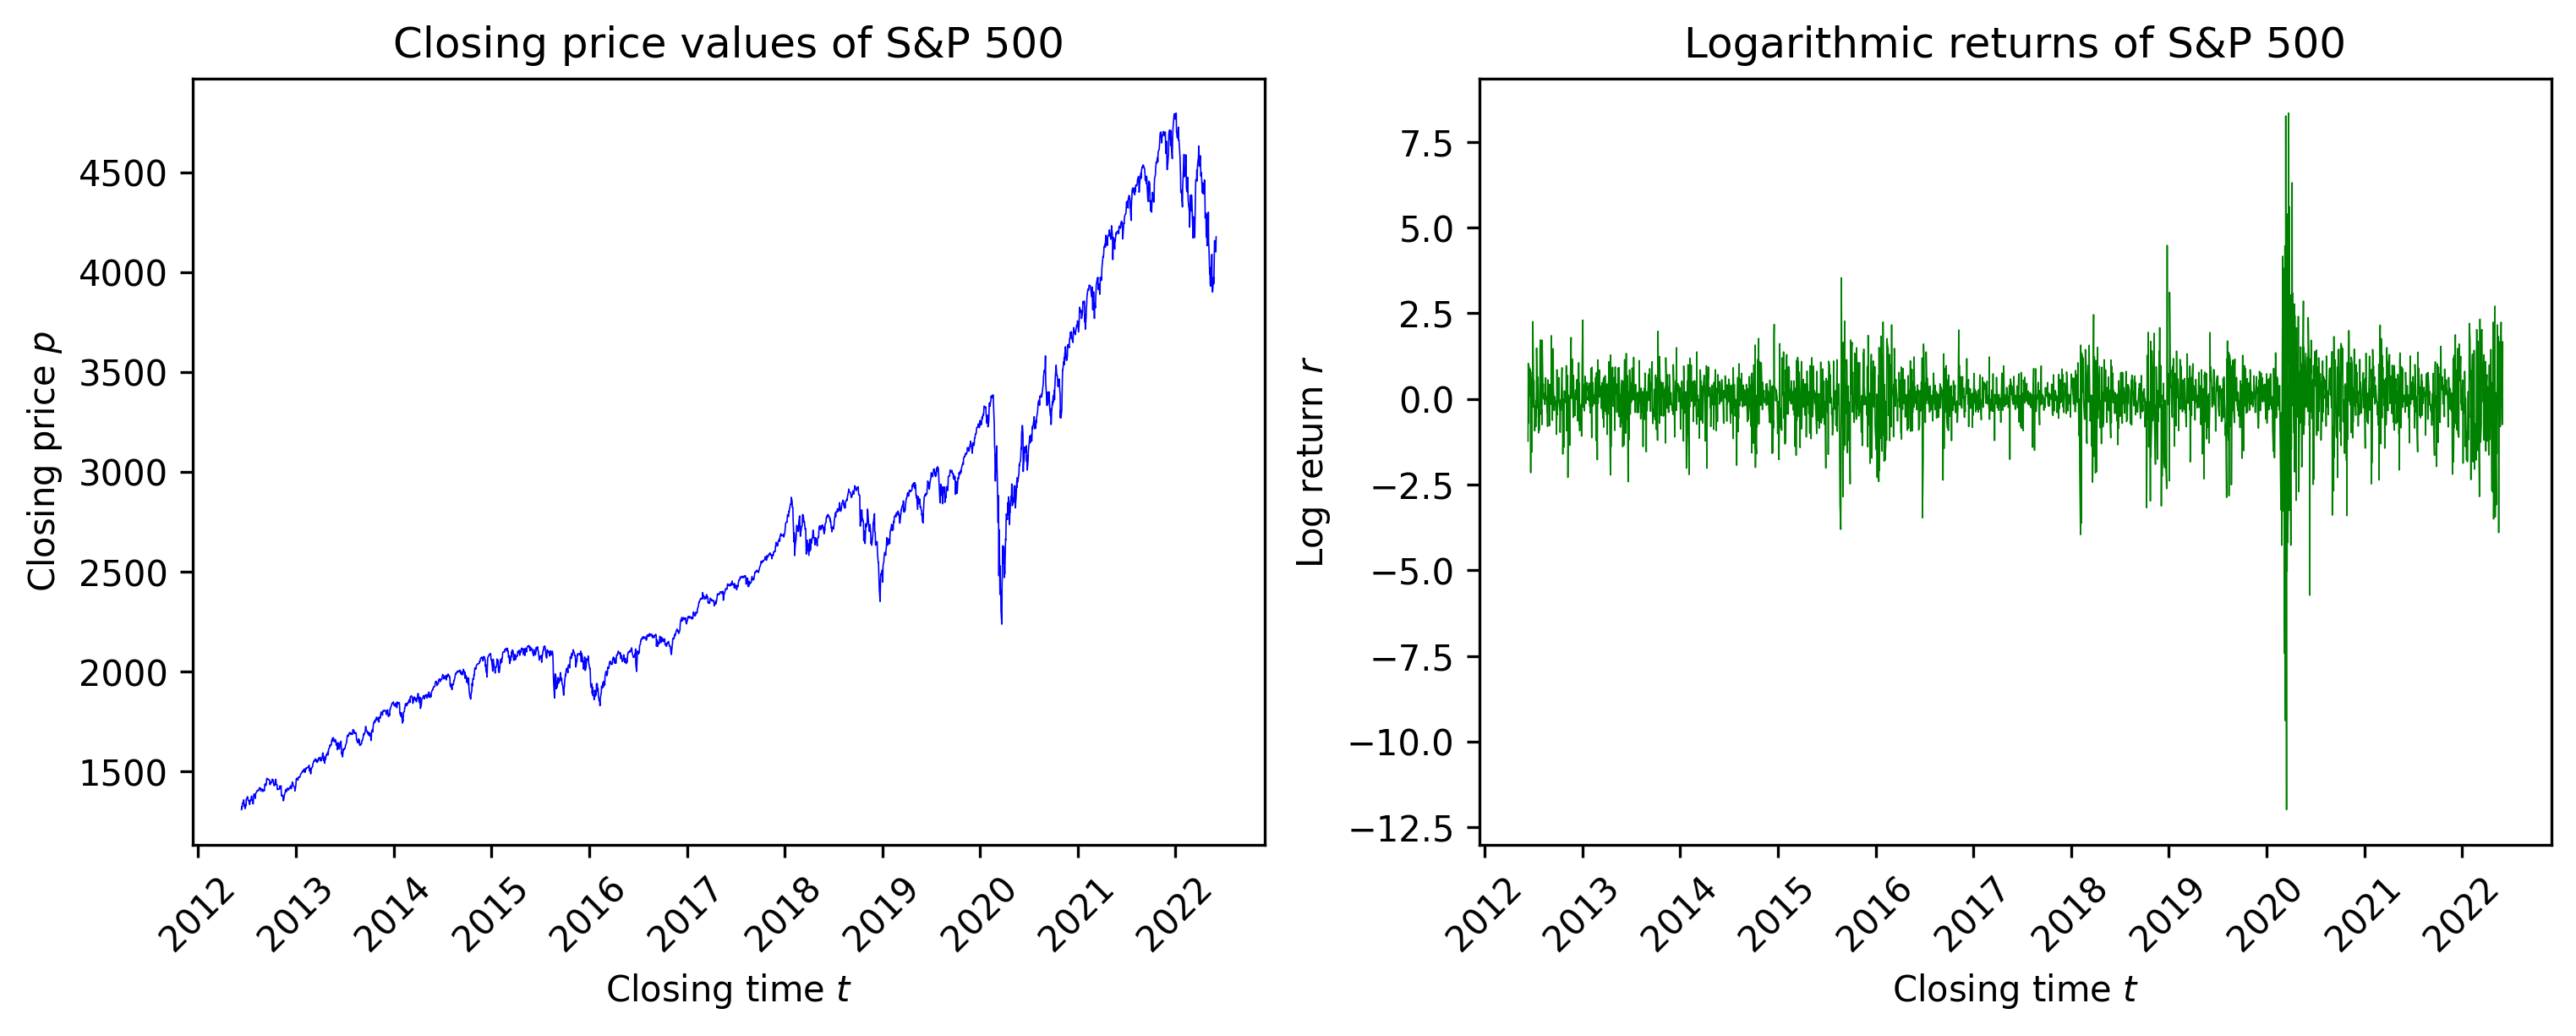

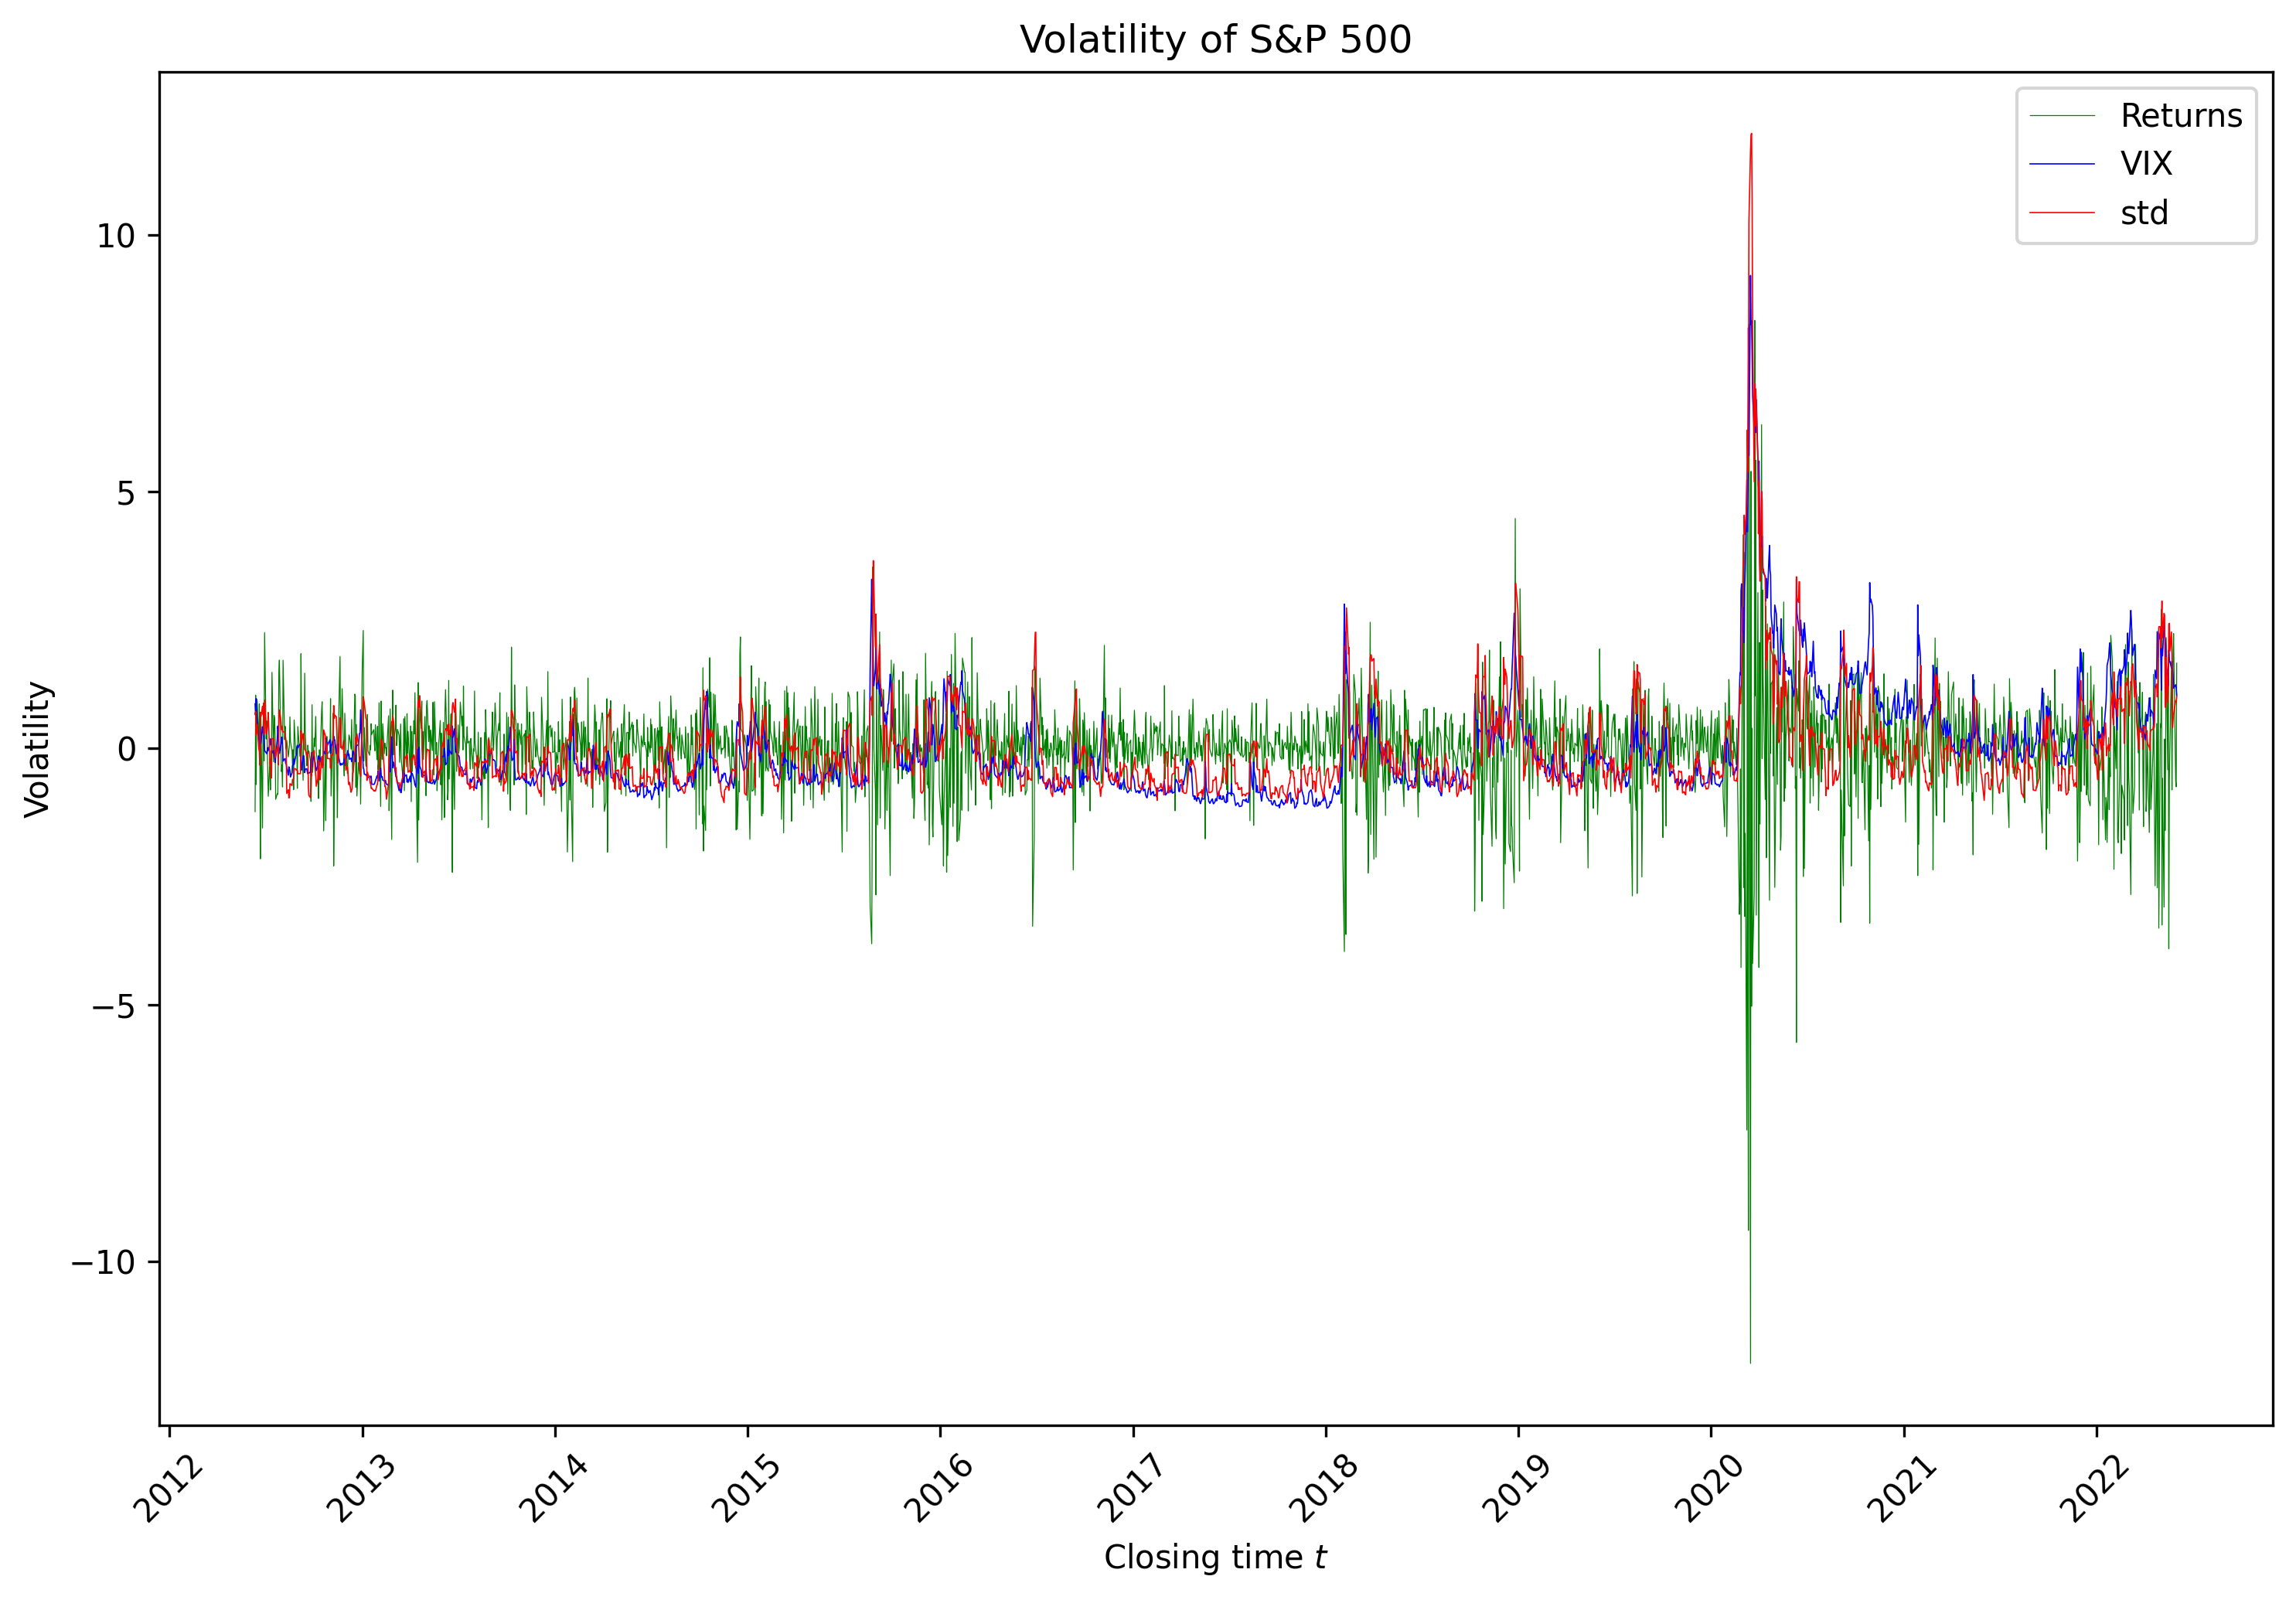

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

ax[0].plot(X.close, linewidth=0.4, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.4, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
ax.plot(X.returns, linewidth=0.3, color='g', label='Returns')
ax.plot(X.vix, linewidth=0.4, color='b', label='VIX')
ax.plot(X.volatility, linewidth=0.4, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [16]:
# build instances X as sequence of 20 vix values, and labels y as subsequent vix value
X_data = []
y_data = []

for i in range(X.vix.shape[0] - LOOKBACK_WINDOW):
    X_data.append(X.vix[i: i + LOOKBACK_WINDOW])
    y_data.append(X.vix[i + LOOKBACK_WINDOW])

X_data = np.array(X_data)
y_data = np.array(y_data)

In [17]:
# split into training and testing data
train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:train_test_split]
X_train = np.expand_dims(X_train, 2)
y_train = y_data[:train_test_split]

X_test = X_data[train_test_split:]
X_test = np.expand_dims(X_test, 2)
y_test = y_data[train_test_split:]

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=0)
# X_train = np.expand_dims(X_train, 2)
# X_test = np.expand_dims(X_test, 2)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((2251, 10, 1), (2251,)), ((251, 10, 1), (251,)))

In [18]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

rnn_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
gru_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
lstm_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
bidir_model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [19]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
bidir_history = bidir_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
71/71 [==============================] - 2s 19ms/step - loss: 0.3392 - mse: 0.5131
Epoch 2/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1643 - mse: 0.0886
Epoch 3/10
71/71 [==============================] - 1s 20ms/step - loss: 0.1586 - mse: 0.0852
Epoch 4/10
71/71 [==============================] - 1s 20ms/step - loss: 0.1553 - mse: 0.0816
Epoch 5/10
71/71 [==============================] - 2s 21ms/step - loss: 0.1535 - mse: 0.0775
Epoch 6/10
71/71 [==============================] - 1s 20ms/step - loss: 0.1593 - mse: 0.0827
Epoch 7/10
71/71 [==============================] - 1s 20ms/step - loss: 0.1660 - mse: 0.0824
Epoch 8/10
71/71 [==============================] - 1s 19ms/step - loss: 0.1545 - mse: 0.0746
Epoch 9/10
71/71 [==============================] - 1s 19ms/step - loss: 0.1527 - mse: 0.0749
Epoch 10/10
71/71 [==============================] - 1s 19ms/step - loss: 0.1529 - mse: 0.0728
Epoch 1/10
71/71 [==============================] - 3s 6ms/

MSE:
    - RNN: 1.0425476752688894
    - GRU: 1.0926296454404918
    - LSTM: 1.0588437825626884
    - Bidirectional LSTM: 1.0707547032439357


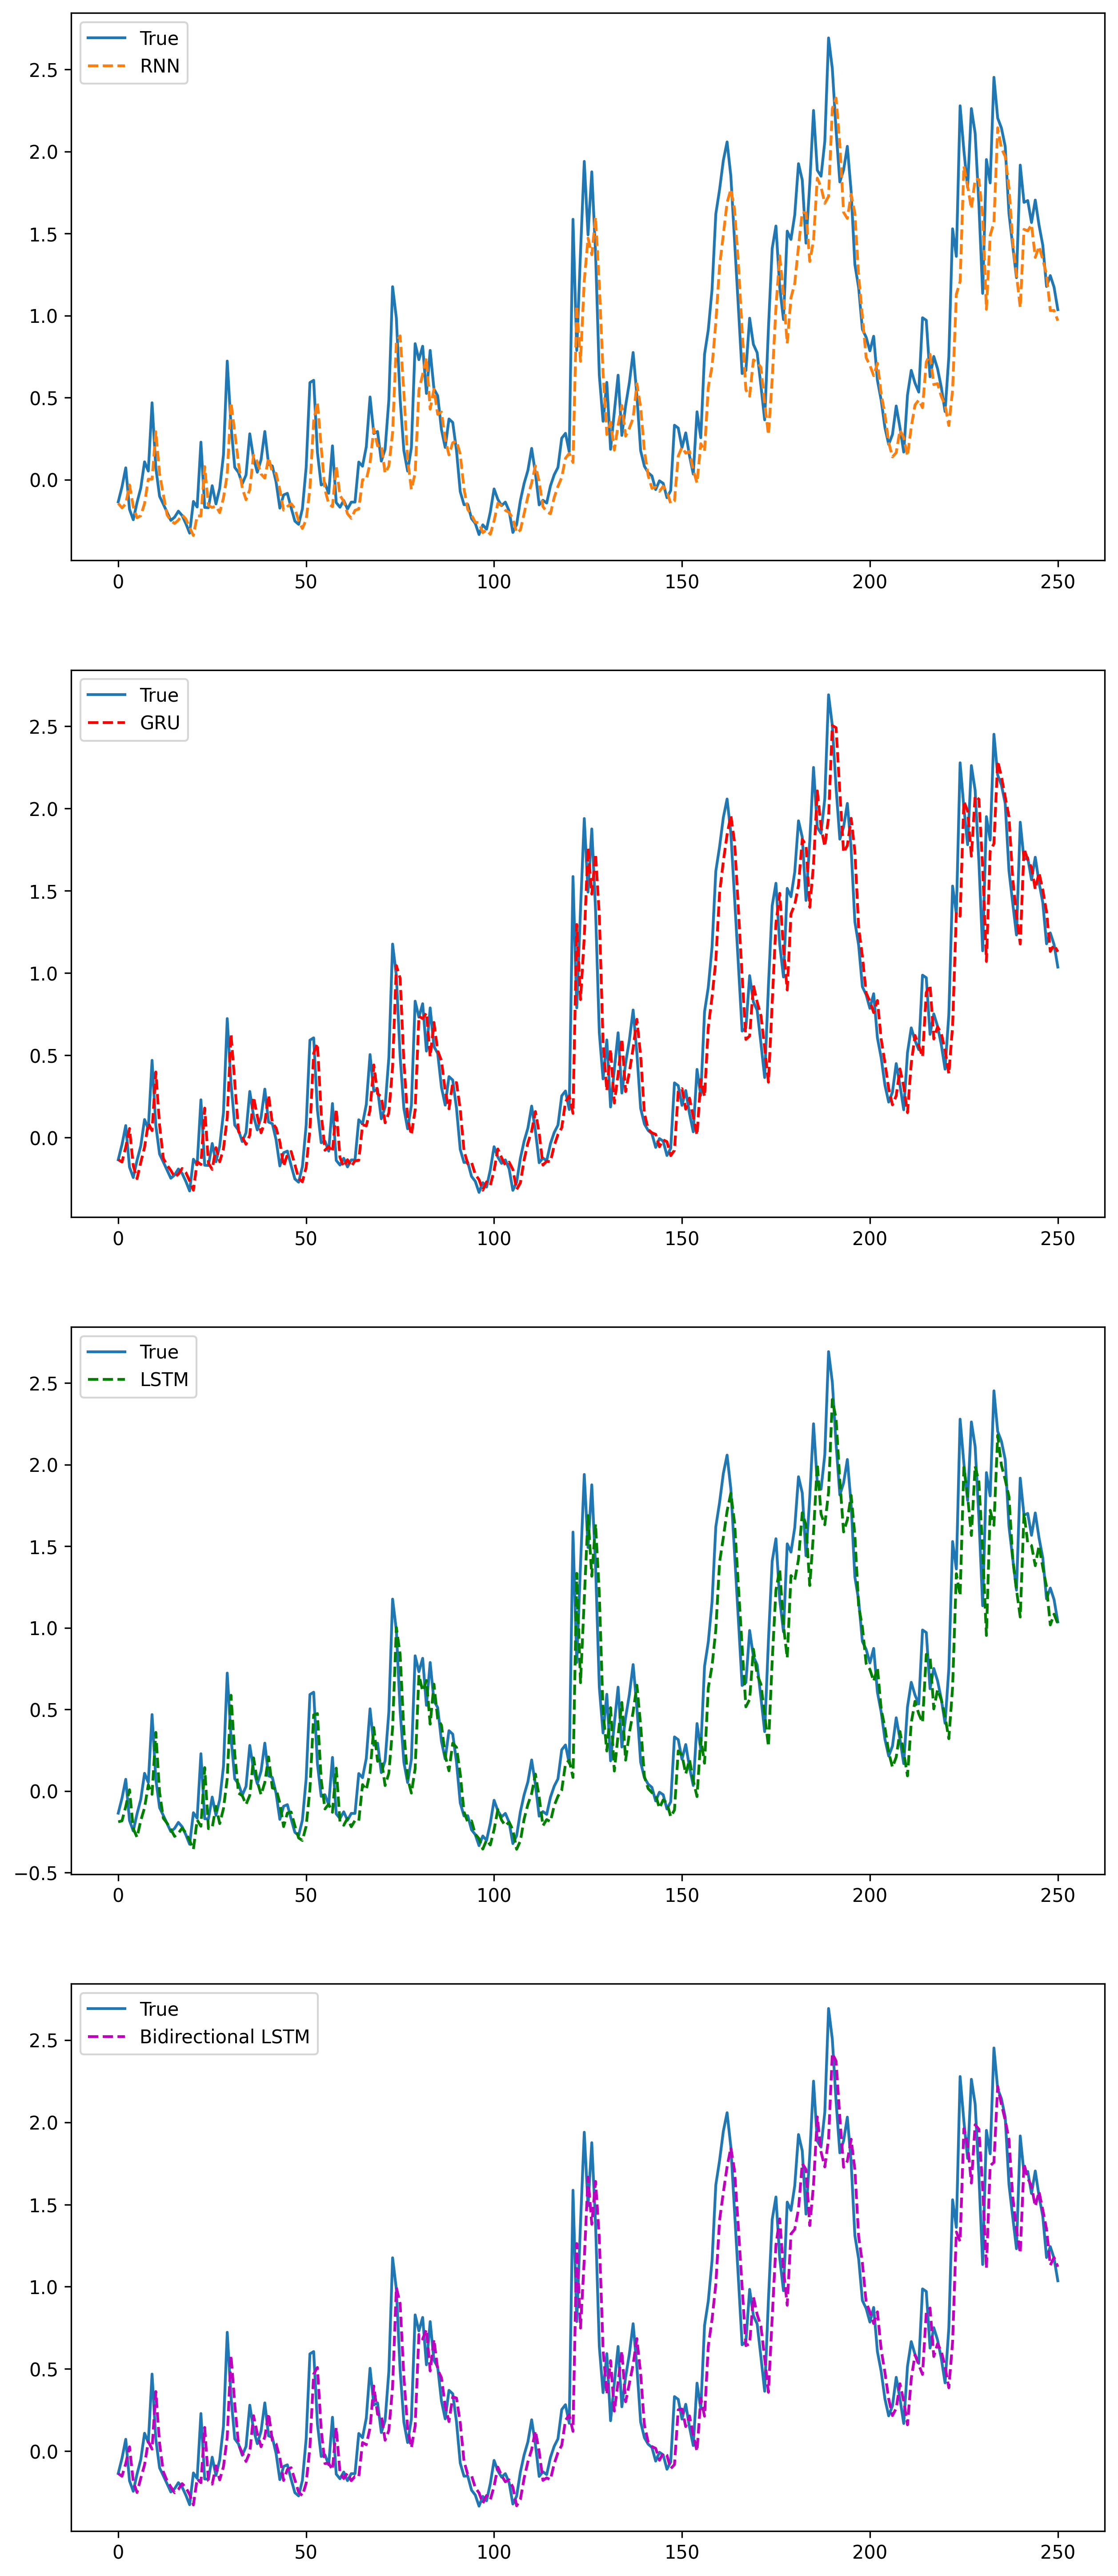

In [20]:
print("MSE:")
rnn_pred = rnn_model.predict(X_test)
rnn_mse = np.square(np.subtract(y_test, rnn_pred)).mean()
print(f"    - RNN: {rnn_mse}")

gru_pred = gru_model.predict(X_test)
gru_mse = np.square(np.subtract(y_test, gru_pred)).mean()
print(f"    - GRU: {gru_mse}")

lstm_pred = lstm_model.predict(X_test)
lstm_mse = np.square(np.subtract(y_test, lstm_pred)).mean()
print(f"    - LSTM: {lstm_mse}")

bidir_pred = bidir_model.predict(X_test)
bidir_mse = np.square(np.subtract(y_test, bidir_pred)).mean()
print(f"    - Bidirectional LSTM: {bidir_mse}")

fig, ax = plt.subplots(4, 1, figsize=(10, 25), dpi=300)

ax[0].plot(y_test, label='True')
ax[0].plot(rnn_pred, linestyle='--', label='RNN')
ax[0].legend(loc=2)

ax[1].plot(y_test, label='True')
ax[1].plot(gru_pred, linestyle='--', color='r', label='GRU')
ax[1].legend(loc=2)

ax[2].plot(y_test, label='True')
ax[2].plot(lstm_pred, linestyle='--', color='g', label='LSTM')
ax[2].legend(loc=2)

ax[3].plot(y_test, label='True')
ax[3].plot(bidir_pred, linestyle='--', color='m', label='Bidirectional LSTM')
ax[3].legend(loc=2)

plt.show()

**All `tanh`**:
- RNN: 1.1130810095024337
- GRU: 1.0368978009809264
- LSTM: 1.0186659784872447
- Bidirectional LSTM: 1.0614774294561649

**All `relu`**:
- RNN: 1.209392633396516
- GRU: 1.0541084374496676
- LSTM: 1.0001606978546216
- Bidirectional LSTM: 1.1196271274279872

**Recurrent `tanh`, dense `linear`**:
- RNN: 0.9900768983959499
- GRU: 1.198882742951503
- LSTM: 1.0672134211422133
- Bidirectional LSTM: 1.0331379002332277

**Recurrent `tanh`, dense default**:
- RNN: 1.1524304137106534
- GRU: 1.1105496000402648
- LSTM: 1.1088816014193532
- Bidirectional LSTM: 1.0757717282319819